# Clustering

## Introduction

Provided brief summary (1 to 2 paragraphs) about your feature data 
, and what you are trying to achieve with your clustering analysis.

## Theory

Write a brief technical write up about how EACH clustering method works (KMEAN, DBSAN, hierarchical clustering). Also include details on model selection methods that you use (elbow, silhouette, etc).
Don’t go “too deep”, around 2 to 4 paragraphs, per method, is fine. Write it in a way that a boss with a non-technical background would understand. Describe the method from a “big picture” point of view, how it works and what it is supposed to do.
Do this “in your own words”. 

In [79]:
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from numpy import linalg as LA

In [80]:
record_data = pd.read_csv('../eda/cars-data.csv')

record_data.head()

,Unnamed: 0,city_mpg,class,combination_mpg,cylinders,displacement,drive,fuel_type,highway_mpg,make,model,transmission,year
0,0,18,midsize car,21,4.0,2.2,fwd,gas,26,toyota,Camry,a,1993
1,1,19,midsize car,22,4.0,2.2,fwd,gas,27,toyota,Camry,m,1993
2,2,16,midsize car,19,6.0,3.0,fwd,gas,22,toyota,Camry,a,1993
3,3,16,midsize car,18,6.0,3.0,fwd,gas,22,toyota,Camry,m,1993
4,4,18,midsize-large station wagon,21,4.0,2.2,fwd,gas,26,toyota,Camry,a,1993


In [81]:
nan_count = record_data.isna().sum()

print(nan_count)

Unnamed: 0          0
city_mpg            0
class               0
combination_mpg     0
cylinders          25
displacement       25
drive               3
fuel_type           0
highway_mpg         0
make                0
model               0
transmission        0
year                0
dtype: int64


In [82]:
record_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       80 non-null     int64  
 1   city_mpg         80 non-null     int64  
 2   class            80 non-null     object 
 3   combination_mpg  80 non-null     int64  
 4   cylinders        55 non-null     float64
 5   displacement     55 non-null     float64
 6   drive            77 non-null     object 
 7   fuel_type        80 non-null     object 
 8   highway_mpg      80 non-null     int64  
 9   make             80 non-null     object 
 10  model            80 non-null     object 
 11  transmission     80 non-null     object 
 12  year             80 non-null     int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 8.3+ KB


In [83]:
# Convert all 'object' type columns to 'string'
for col in record_data.select_dtypes(include=['object']).columns:
    record_data[col] = record_data[col].astype('string')

# Verify the changes
record_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       80 non-null     int64  
 1   city_mpg         80 non-null     int64  
 2   class            80 non-null     string 
 3   combination_mpg  80 non-null     int64  
 4   cylinders        55 non-null     float64
 5   displacement     55 non-null     float64
 6   drive            77 non-null     string 
 7   fuel_type        80 non-null     string 
 8   highway_mpg      80 non-null     int64  
 9   make             80 non-null     string 
 10  model            80 non-null     string 
 11  transmission     80 non-null     string 
 12  year             80 non-null     int64  
dtypes: float64(2), int64(5), string(6)
memory usage: 8.3 KB


In [84]:
# get y 

y = record_data['fuel_type'].unique().tolist()

y

['gas', 'electricity']

In [85]:
# Dropping non-numerical and unnecessary columns
record_data = record_data.drop(columns=['Unnamed: 0'])

In [86]:
# Replace continuous missing values with mean of the column. check for Nan values again.

cols = ['displacement', 'cylinders']
record_data[cols] = record_data[cols].fillna(record_data[cols].mean())

nan_count = record_data.isna().sum()
print(nan_count)

city_mpg           0
class              0
combination_mpg    0
cylinders          0
displacement       0
drive              3
fuel_type          0
highway_mpg        0
make               0
model              0
transmission       0
year               0
dtype: int64


In [87]:
# Replace categorical missing values with mode of the column. check for Nan values again.

record_data['drive'] = record_data['drive'].fillna(record_data['drive'].mode().iloc[0])

nan_count = record_data.isna().sum()
print(nan_count)

city_mpg           0
class              0
combination_mpg    0
cylinders          0
displacement       0
drive              0
fuel_type          0
highway_mpg        0
make               0
model              0
transmission       0
year               0
dtype: int64


In [88]:
# Using a for loop to replace categorical values with cat codes
cat_cols = ['class', 'drive', 'fuel_type', 'make', 'model', 'transmission']
for col in cat_cols:
    record_data[col] = record_data[col].astype('category')
    record_data[col] = record_data[col].cat.codes

# Display the altered DataFrame
record_data.head()

,city_mpg,class,combination_mpg,cylinders,displacement,drive,fuel_type,highway_mpg,make,model,transmission,year
0,18,2,21,4.0,2.2,1,1,26,6,3,0,1993
1,19,2,22,4.0,2.2,1,1,27,6,3,1,1993
2,16,2,19,6.0,3.0,1,1,22,6,3,0,1993
3,16,2,18,6.0,3.0,1,1,22,6,3,1,1993
4,18,3,21,4.0,2.2,1,1,26,6,3,0,1993


In [89]:
# Split the dataset in X and y. since this is unsupervised learning, we will not use the y labels. you can choose to normalize the X data by using the StandardScaler function.

x_cols = ['city_mpg', 'class', 'combination_mpg', 'cylinders', 'displacement', 'drive', 'highway_mpg', 'make', 'model', 'transmission', 'year' ]
y_cols = ['fuel_type']

X = record_data[x_cols]  #'fuel_type' is the column we want to predict.
y = record_data[y_cols]


X = StandardScaler().fit_transform(X)

### KMEAN

In [90]:
# import relevent libraries for clustering. we will use KMeans, AgglomerativeClustering, MeanShift, Birch, and DBSCAN

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

In [91]:
# code modified from: https://medium.com/nerd-for-tech/k-means-clustering-using-python-2150769bd0b9

In [92]:
#get the value from the features in array format
features_value = X
features_value

array([[-0.62883646, -0.73831341, -0.61329244, -1.17319439, -0.9119434 ,
         0.13303802, -0.5762842 ,  1.25937568, -0.97618706, -0.55809982,
        -0.90149708],
       [-0.60370813, -0.73831341, -0.58645251, -1.17319439, -0.9119434 ,
         0.13303802, -0.54706827,  1.25937568, -0.97618706,  1.79179416,
        -0.90149708],
       [-0.67909312, -0.73831341, -0.66697231,  0.52485012,  0.06434637,
         0.13303802, -0.69314792,  1.25937568, -0.97618706, -0.55809982,
        -0.90149708],
       [-0.67909312, -0.73831341, -0.69381224,  0.52485012,  0.06434637,
         0.13303802, -0.69314792,  1.25937568, -0.97618706,  1.79179416,
        -0.90149708],
       [-0.62883646, -0.4501911 , -0.61329244, -1.17319439, -0.9119434 ,
         0.13303802, -0.5762842 ,  1.25937568, -0.97618706, -0.55809982,
        -0.90149708],
       [-0.50319481, -1.31455802, -0.53277265, -1.17319439, -1.64416072,
         0.13303802, -0.5762842 ,  1.25937568, -0.54232614, -0.55809982,
        -0.901

In [93]:
#finding the optimal number of k for clustering using elbow method
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

inertia = []
distortions = []

K = range(1,11)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(features_value)
    inertia.append(km.inertia_)
    distortions.append(sum(np.min(cdist(features_value,
    km.cluster_centers_, 'euclidean'),axis=1)) /
    features_value.shape[0])

/Users/isfarbaset/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/isfarbaset/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/isfarbaset/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/isfarbaset/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init

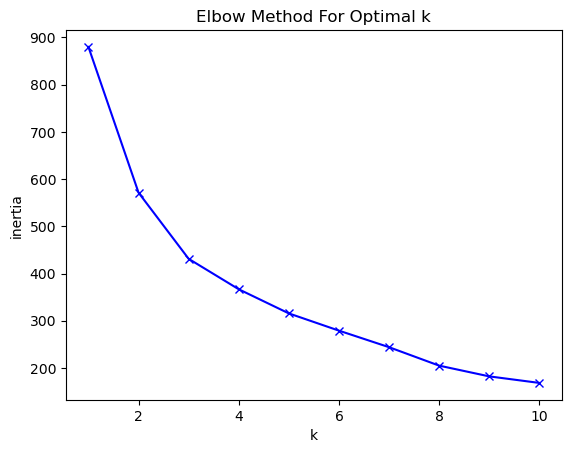

In [94]:
#Plotting the inertia result to find the elbow
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [95]:
df = pd.DataFrame({
    'Cluster': list(K),
    'Distortion': distortions,
    'Inertia': inertia
})

# Display the DataFrame
print(df)

   Cluster  Distortion     Inertia
0        1    3.253657  880.000000
1        2    2.569123  571.256625
2        3    2.247452  431.099415
3        4    2.070557  366.611791
4        5    1.944560  315.472570
5        6    1.784091  278.940236
6        7    1.667732  243.883631
7        8    1.548023  204.809253
8        9    1.448900  182.052608
9       10    1.351605  168.195316


In [96]:
# plot distortion and inertia for kmeans, you can either plot them seperately or use fig, ax = plt.subplots(1, 2) to plot them in the same figure. Suggest the optimal number of clusters based on the plot.

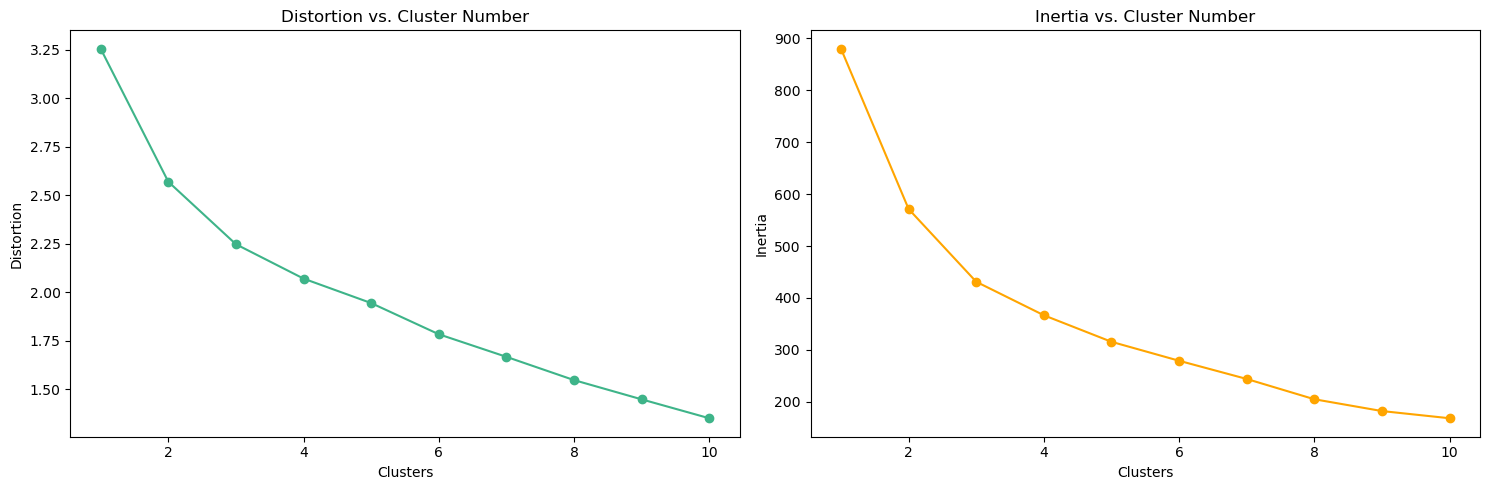

In [97]:
# Creating subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting Distortion
ax[0].plot(K, distortions, marker='o', color='#3EB489')
ax[0].set_title('Distortion vs. Cluster Number')
ax[0].set_xlabel('Clusters')
ax[0].set_ylabel('Distortion')

# Plotting Inertia
ax[1].plot(K, inertia, marker='o', color='#FFA500')
ax[1].set_title('Inertia vs. Cluster Number')
ax[1].set_xlabel('Clusters')
ax[1].set_ylabel('Inertia')

plt.tight_layout()
plt.show()


### DBSCAN

In [98]:
# perform DBSCAN clustering. use the eps and min_samples parameters to find the optimal number of clusters. plot the number of clusters vs the silhouette score. Suggest the optimal number of clusters based on the plot.

import sklearn.cluster

# UTILITY FUNCTION
# THIS WILL ITERATE OVER ONE HYPER-PARAMETER (GRID SEARCH)
# AND RETURN THE CLUSTER RESULT THAT OPTIMIZES THE SILHOUETTE SCORE
def maximize_silhouette(X,algo="birch",nmax=20,i_plot=False):

    # PARAM
    i_print=False

    #FORCE CONTIGUOUS
    X=np.ascontiguousarray(X)

    # LOOP OVER HYPER-PARAM
    params=[]; sil_scores=[]
    sil_max=-10
    for param in range(2,nmax+1):
        if(algo=="birch"):
            model = sklearn.cluster.Birch(n_clusters=param).fit(X)
            labels=model.predict(X)

        if(algo=="ag"):
            model = sklearn.cluster.AgglomerativeClustering(n_clusters=param).fit(X)
            labels=model.labels_

        if(algo=="dbscan"):
            param=0.25*(param-1)
            model = sklearn.cluster.DBSCAN(eps=param).fit(X)
            labels=model.labels_

        if(algo=="kmeans"):
            model = sklearn.cluster.KMeans(n_clusters=param).fit(X)
            labels=model.predict(X)

        try:
            sil_scores.append(sklearn.metrics.silhouette_score(X,labels))
            params.append(param)
        except:
            continue

        if(i_print): print(param,sil_scores[-1])

        if(sil_scores[-1]>sil_max):
             opt_param=param
             sil_max=sil_scores[-1]
             opt_labels=labels

    print("OPTIMAL PARAMETER =",opt_param)

    if(i_plot):
        fig, ax = plt.subplots()
        ax.plot(params, sil_scores, "-o")
        ax.set(xlabel='Hyper-parameter', ylabel='Silhouette')
        plt.show()

    return opt_labels

In [99]:
# UTILITY PLOTTING FUNCTION
def plot(X,color_vector):
    fig, ax = plt.subplots()
    ax.scatter(X[:,0], X[:,1],c=color_vector, alpha=0.5) #, c=y
    ax.set(xlabel='Feature-1 (x_1)', ylabel='Feature-2 (x_2)',
    title='Cluster data')
    ax.grid()
    # fig.savefig("test.png")
    plt.show()

# plot(X,y)

OPTIMAL PARAMETER = 3.0


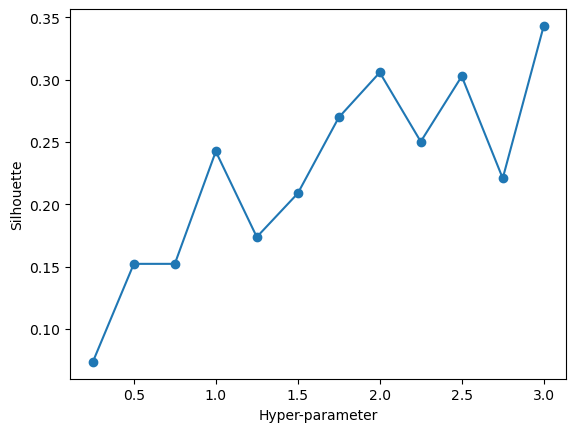

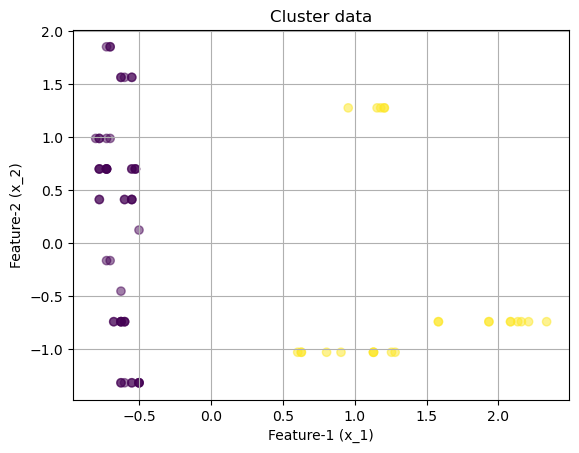

In [100]:
# DBSCAN
opt_labels=maximize_silhouette(X,algo="dbscan",nmax=15, i_plot=True)
plot(X,opt_labels)

### Hierchical Clustering

OPTIMAL PARAMETER = 15


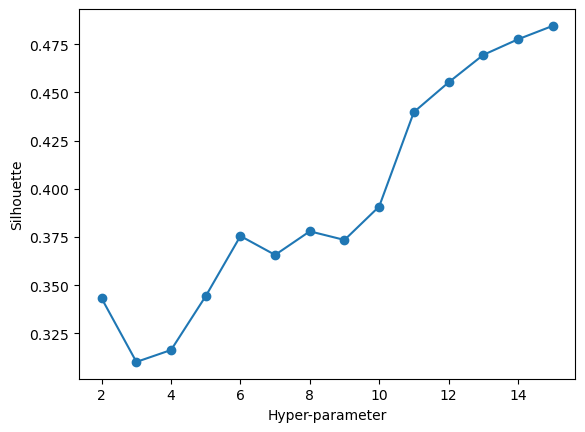

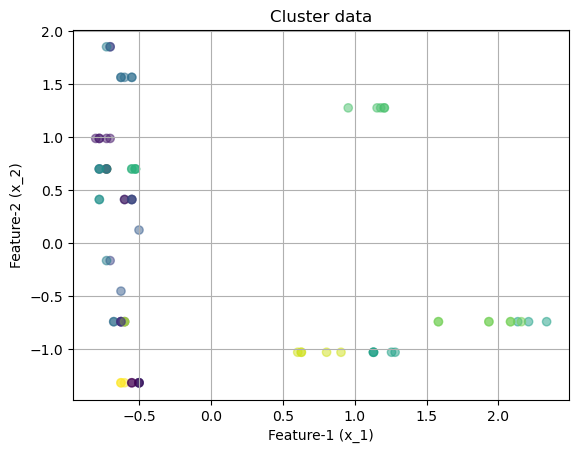

In [101]:
# Perform Agglomerative Clustering

# AGGLOMERATIVE CLUSTERING
opt_labels=maximize_silhouette(X,algo="ag",nmax=15, i_plot=True)
plot(X,opt_labels)

In [102]:
# create linkage for agglomerative clustering, and the dendrogram for the linkage. Suggest the optimal number of clusters based on the dendrogram.

from scipy.cluster.hierarchy import linkage, dendrogram

complete_clustering = linkage(X, method="complete", metric="euclidean")
average_clustering = linkage(X, method="average", metric="euclidean")
single_clustering = linkage(X, method="single", metric="euclidean")

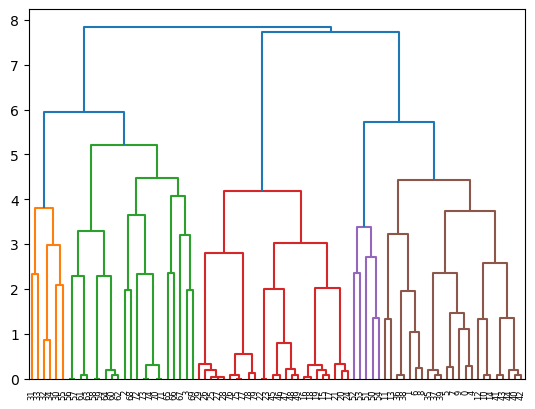

In [103]:
dendrogram(complete_clustering)
plt.show()

## Methods

In this section, describe your coding workflow;
If you are not using Quarto, then provide links to the relevant code in this section.
If you are using Quarto (recommended), then include your code in-line using the “code folding” option, so that users can toggle the code on/off as needed. The notebook should also be hosted on Github. You can always do the entire thing in .ipynb then render it to HTML using Quarto at the end.

### Data Selection

If you have not done so already, create either a numeric record feature dataset 
 AND/OR a text feature dataset 
 from your existing data.
Remove the labels (targets) 
 as needed so that it is suitable for clustering.
If you have labels, you can use them at the end, to check if the clustering predictions coincided with the existing labels in the data-set. In general this may or may-not be true.
But these labels should not be used as part of the clustering analysis.

### Feature Selection

(optional)
If you want, you can perform filter based feature selection on your data-set 
 as a pre-processing step before clustering
You can also use optimal feature sets obtained during previous assignments


### Hyper-parameter tuning

For each of the three clustering algorithms, perform any relevant parameter tuning in an attempt to achieve the optimal clustering results
e.g. For k-means, Use Elbow and Silhouette methods to illustrate the ideal number of clusters. Visualize your results.
Also, when relevant, explore different choices of distance metric for the algorithm. Which distance metric seems to works best in which cases and why?

### FInal Results

Once you have everything “dialed in”, re-do the analysis one last time with the optimal parameter choice to get your “final results”.

## Results

Using your “final results”, discuss, illustrate, and compare the results of your various clustering analysis methods.
Which method seemed to work the best and why, which was easier to use or preferable, etc.
Can you make connections between the optimal cluster predictions, after parameter tuning, with any of the labels in the data set. Do they coincide? Why or why not?
Did the clustering results provide any new insights into your data?
Explore the results, and create as many meaningful visualizations as you need. Be creative, and experiment with different image aesthetics.
Ensure all visualizations are professional, ascetically pleasing, labeled, captioned, use color, are clear, and support your discussion and goals.

## Conslusions

In this section, the goal is to summarize & wrap-up the report. It explains what was found, in a way that would make sense to a general readership.
This area is non-technical. Technical descriptions of what you did should be in the methods or results sections, not conclusions.
The Conclusions should focus on key and important findings and how these findings affect real-life and real people.

## References

Reference all non-original content.
Ideally (but optionally) use .bibtex combined with Quarto to provide in-line internal citations
See the following link for an example:
https://drive.google.com/open?